# Transformer模型

Transformer架构
- 基于编码器-解码器架构来处理序列对
- 跟使用注意力的Seq2Seq不同，Transformer是纯基于注意力机制

多头注意力
- 对同一key、value、query，希望抽取不同的信息
    - 例如短距离关系和长距离关系
- 多头注意力使用h个独立的注意力池化
    - 合并各个头(head)输出得到最终输出

有掩码的多头注意力
- 解码器对序列中一个元素输出时，不应该考虑该元素之后的元素
- 可以通过掩码实现
    - 也就是计算xi输出时，假装当前序列长度为i

基于位置的前馈神经网络
- 将输入形状由(b,n,d)变换成(bn,d)
- 作用两个全连接层
- 输出形状由(bn,d)变化回(b,n,d)
- 等价于两层核窗口为1的一维卷积层

层归一化
- 批量归一化对每个特征/通道里元素进行归一化
    - 不适合序列长度会变的NLP应用
- 层归一化对每个样本里的元素进行归一化

信息传递
- 编码器中的输出y1,...,yn
- 将其作为解码的第i个Transformer块中多头注意力的key和value
    - 它的query来自目标序列
- 意味着编码器和解码器中块的个数和输出维度都是一样的

预测 
- 预测第t+1个输出时
- 解码器中输入前t个预测值
    - 在自注意力中，前t个预测值作为key和value，第t个预测值还作为query

总结
- Transformer是一个纯使用注意力的解码器-编码器
- 编码器和解码器都有n个Transformer块
- 每个块里使用多头自注意力，基于位置的前馈神经网络和层归一化

In [1]:
#导入第三方库
import math, torch
import pandas as pd
from torch import nn
from d2l import torch as d2l

d:\Anaconda\envs\d2l-zh\lib\site-packages\torch\_subclasses\functional_tensor.py:258: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [5]:
#基于位置的前馈网络
class PointWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, 
                 ffn_num_outputs, **kwargs):
        super(PointWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [6]:
#用同一个MLP对所有位置上的输入进行变换，得到相同的输出
ffn = PointWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.0492, -0.2043, -0.1696,  0.3732, -0.1407,  0.1016, -0.2251, -0.3534],
        [ 0.0492, -0.2043, -0.1696,  0.3732, -0.1407,  0.1016, -0.2251, -0.3534],
        [ 0.0492, -0.2043, -0.1696,  0.3732, -0.1407,  0.1016, -0.2251, -0.3534]],
       grad_fn=<SelectBackward0>)

In [7]:
#残差连接和层归一化
#对比不同维度的层归一化和批量归一化效果
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [3, 4]], dtype= torch.float32)
#训练模式下计算x的均值和方差
print('layer norm:', ln(X), 'batch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [8]:
#定义AddNorm类
class AddNorm(nn.Module):
    """残差连接和层归一化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [11]:
#测试AddNorm类
add_norm = AddNorm(normalized_shape=[3, 4], dropout= 0.5)
#设置为验证模式
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [14]:
#编码器类
#包含两个子类：多头注意力和基于位置的前馈网络
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, 
                 use_bias= False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention= d2l.MultiHeadAttention(key_size, query_size, value_size, 
                                               num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        #编码器中ffn模块输出的数量为整个模型的隐藏层数量
        #用作解码器的输入
        self.ffn = PointWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [15]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
#设置编码器块为验证状态
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [26]:
#Transformer编码器：堆叠了num_layers个EncoderBlock类的实例
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, 
                 value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                 num_heads, num_layers, dropout, use_bias= False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_heads = num_heads
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        #定义Sequential构造器
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i), 
                                 EncoderBlock(key_size, query_size, value_size, 
                                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                                 num_heads, dropout, use_bias))
    
    def forward(self, X, valid_lens, *args):
        #位置编码值在-1和1之间
        #嵌入值乘以嵌入维度的平方根进行缩放
        #与位置编码进行相加
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [23]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype= torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [20]:
#解码器
class DecoderBlock(nn.Module):
    """构建解码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, 
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, 
                                                num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PointWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        #解码器的第一层部分输入由encoder的最后一层隐藏状态提供
        enc_outputs, enc_valid_lens = state[0], state[1] 
        #训练阶段，输出序列的所有词元都在同一时间处理
        #因此state[2][self.i]初始化为None
        #预测阶段：输出序列是通过词元一个一个编码的
        #因此state[2][self.i]包含直到当前时间步第i块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            #将当前状态与X连接
            key_values = torch.cat((state[2][self.i], X), axis= 1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            #dec_valid_lens的开头:(batch_size, num_steps),
            #其中每一行是[1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device= X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        #自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        #编码器-解码器注意力机制
        #enc_outputs的开头：(batch_size, num_steps, num_hiddens)
        Y2= self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [21]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [28]:
#构建由num_layers个DecoderBlock实例组成的完整的Transformer解码器
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, 
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens, 
                                              norm_shape, ffn_num_input, ffn_num_hiddens, 
                                              num_heads, dropout, i))
            self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            #解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            #"编码器——解码器"自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.032, 6896.9 tokens/sec on cuda:0


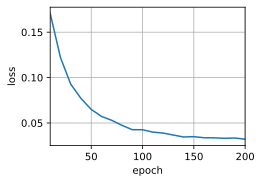

In [29]:
#在英语-法语数据集上训练Transformer模型
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             num_layers, dropout)

decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             num_layers, dropout)

net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [30]:
#执行预测并计算BLEU分数
engs = ['go .', 'i lost .', 'he\'s clam .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est clame .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng}=> {translation}, ', f'bleu {d2l.bleu(translation, fra, k= 2):.3f}')

go .=> va !,  bleu 1.000
i lost .=> j'ai perdu .,  bleu 1.000
he's clam .=> il est <unk> .,  bleu 0.658
i'm home .=> je suis chez moi .,  bleu 1.000
